In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import make_moons

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
from tools import *

assert(torch.cuda.is_available())
device = torch.device("cuda")

<Axes: >

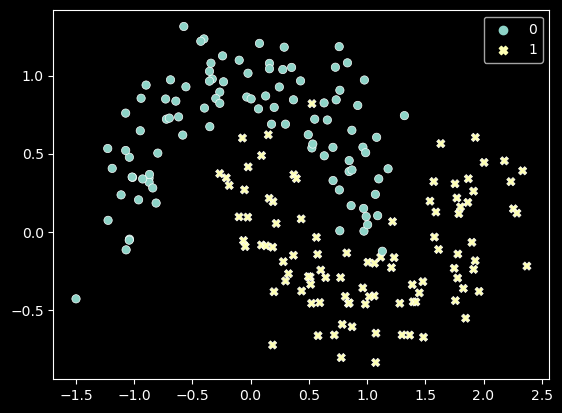

In [2]:
X_train, y_train = make_moons(n_samples=8000, noise=0.2)
X_test, y_test = make_moons(n_samples=200, noise=0.2)
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_test, style=y_test)


In [3]:
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
testing_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

optimizer = torch.optim.AdamW(model.parameters())
f_loss = nn.CrossEntropyLoss()

In [4]:
y_hat_epoch = run_epoch( model, f_loss, optimizer, testing_loader, score_funcs=None, computing_device=device, desc=None, show_progress=True)

In [5]:
len(y_hat_epoch)

200

In [8]:
y_hat_epoch.shape
#concatenate these arrays along the first dimension

(200, 2)

In [7]:
np.mean([1, 2])

a = torch.tensor([1, 2])
b = a.detach()
b[0] = 5
a

tensor([5, 2])